In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from lightgbm import LGBMClassifier

# Initial Data Exploration & Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Flight Delay Prediction/flights.csv")
df

/tmp/ipython-input-563813145.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Flight Delay Prediction/flights.csv")


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna(subset=['ARRIVAL_DELAY', 'DEPARTURE_DELAY'])
df['FLIGHT_DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

weekday = {1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',7:'Sunday'}
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].map(weekday)

df['MONTH'] = df['FLIGHT_DATE'].dt.month
df['DAY'] = df['FLIGHT_DATE'].dt.day

df['DEPARTURE_TIME'] = pd.to_datetime(df['DEPARTURE_TIME'], format='%H%M', errors='coerce')
df['ARRIVAL_TIME'] = pd.to_datetime(df['ARRIVAL_TIME'], format='%H%M', errors='coerce')
mask = df['ARRIVAL_TIME'] < df['DEPARTURE_TIME']
df.loc[mask, 'ARRIVAL_TIME'] += pd.Timedelta(days=1)
df['FLIGHT_DURATION'] = (df['ARRIVAL_TIME'] - df['DEPARTURE_TIME']).dt.total_seconds() / 60
df['FLIGHT_DURATION'] = df['FLIGHT_DURATION'].fillna(df['SCHEDULED_TIME'])
df['HOUR'] = df['DEPARTURE_TIME'].dt.hour

df['DEPARTURE_DELAY_MINUTES'] = df['DEPARTURE_DELAY']
df['ARRIVAL_DELAY_MINUTES'] = df['ARRIVAL_DELAY']

df['DELAYED'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)
df['DEPARTURE_DELAY_FLAG'] = df['DEPARTURE_DELAY'].apply(lambda x: 1 if x > 15 else 0)
df['ARRIVAL_DELAY_FLAG'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)

delay_reason_cols = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
df[delay_reason_cols] = df[delay_reason_cols].fillna(0)
df = df.dropna(subset=['DEPARTURE_TIME', 'ARRIVAL_TIME'])

df = df.drop_duplicates()

/tmp/ipython-input-1272166553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FLIGHT_DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
/tmp/ipython-input-1272166553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].map(weekday)
/tmp/ipython-input-1272166553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [ ]:
print(df.head())
print(df.shape)
print(df.dtypes)
print(df.describe())
print(df.isnull().sum())
print(df['ARRIVAL_DELAY_FLAG'].value_counts(normalize=True))
print(df['DEPARTURE_DELAY_FLAG'].value_counts(normalize=True))

   YEAR  MONTH  DAY DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1    Thursday      AS             98      N407AS   
2  2015      1    1    Thursday      US            840      N171US   
3  2015      1    1    Thursday      AA            258      N3HYAA   
4  2015      1    1    Thursday      AS            135      N527AS   
5  2015      1    1    Thursday      DL            806      N3730B   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  ...  \
0            ANC                 SEA                    5  ...   
2            SFO                 CLT                   20  ...   
3            LAX                 MIA                   20  ...   
4            SEA                 ANC                   25  ...   
5            SFO                 MSP                   25  ...   

  LATE_AIRCRAFT_DELAY  WEATHER_DELAY  FLIGHT_DATE  FLIGHT_DURATION  HOUR  \
0                 0.0            0.0   2015-01-01            254.0  23.0   
2                 0.0         

# EDA

/tmp/ipython-input-4173151247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HOUR', y='DEPARTURE_DELAY_FLAG', data=delay_by_hour, palette='viridis')


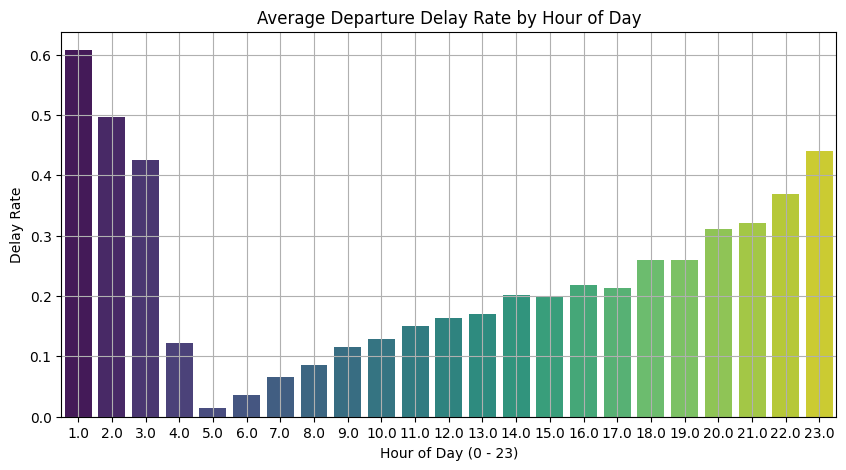

/tmp/ipython-input-4173151247.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=AIRLINE_DELAY.index, y=AIRLINE_DELAY.values, palette="viridis")


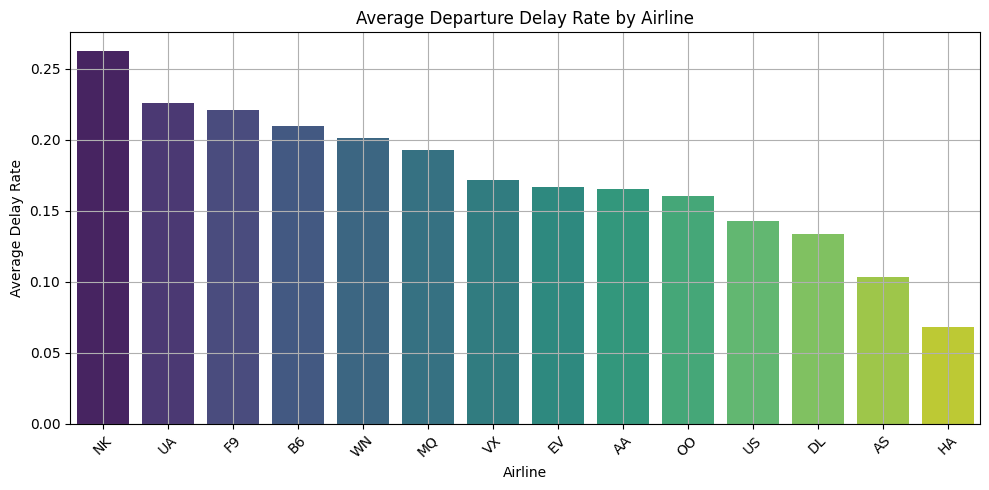

/tmp/ipython-input-4173151247.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_delay.index, y=month_delay.values, palette="coolwarm")


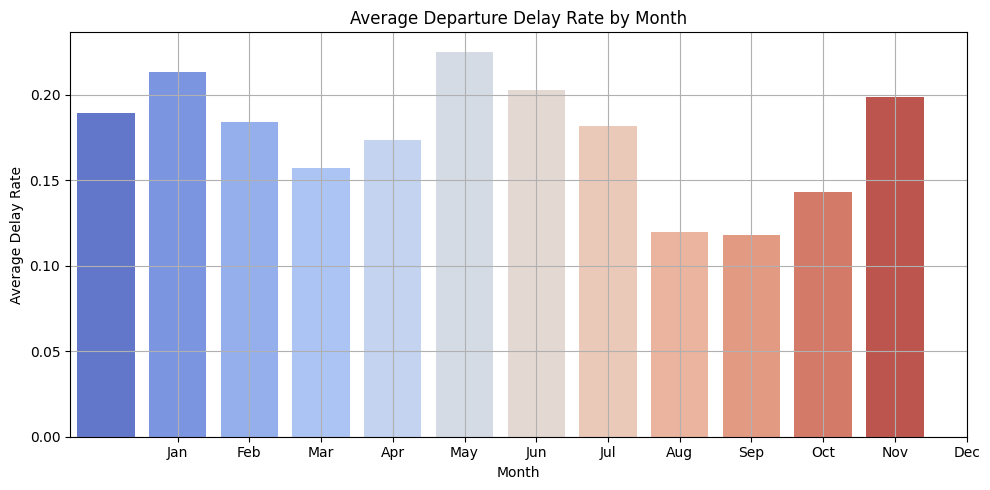

/tmp/ipython-input-4173151247.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_delay.index, y=dow_delay.values, palette="magma")


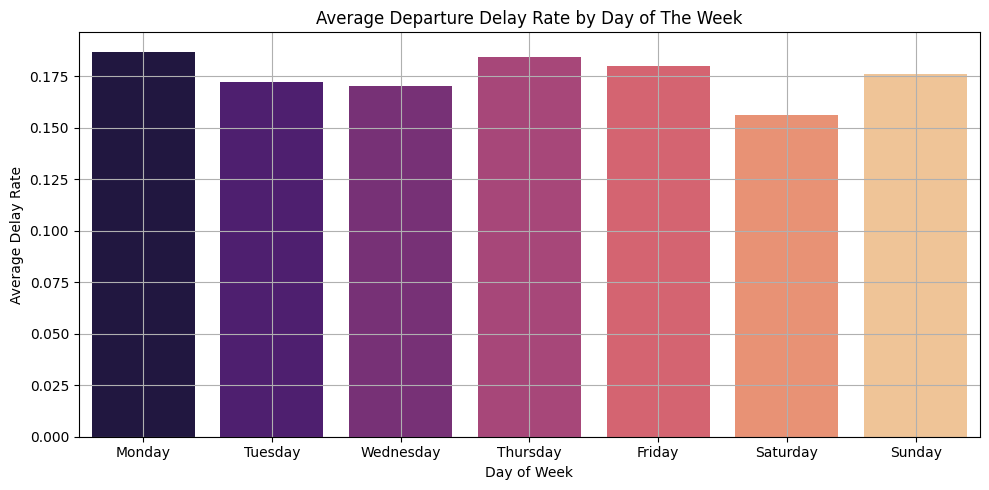

/tmp/ipython-input-4173151247.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ORIGIN_DELAY.index, y=ORIGIN_DELAY.values, palette='rocket')


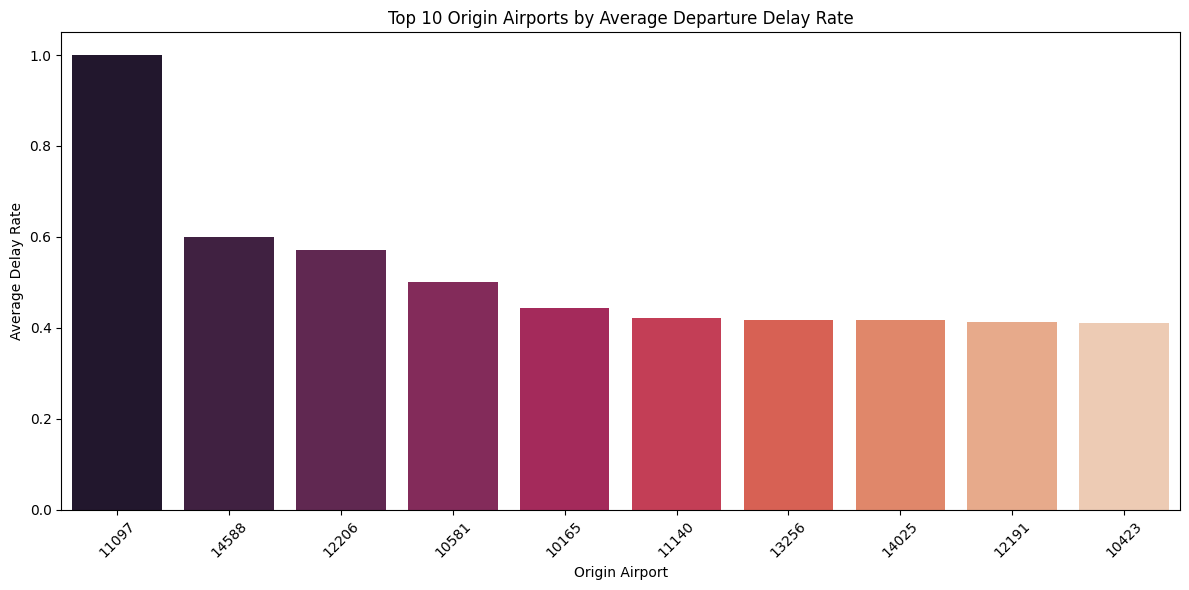

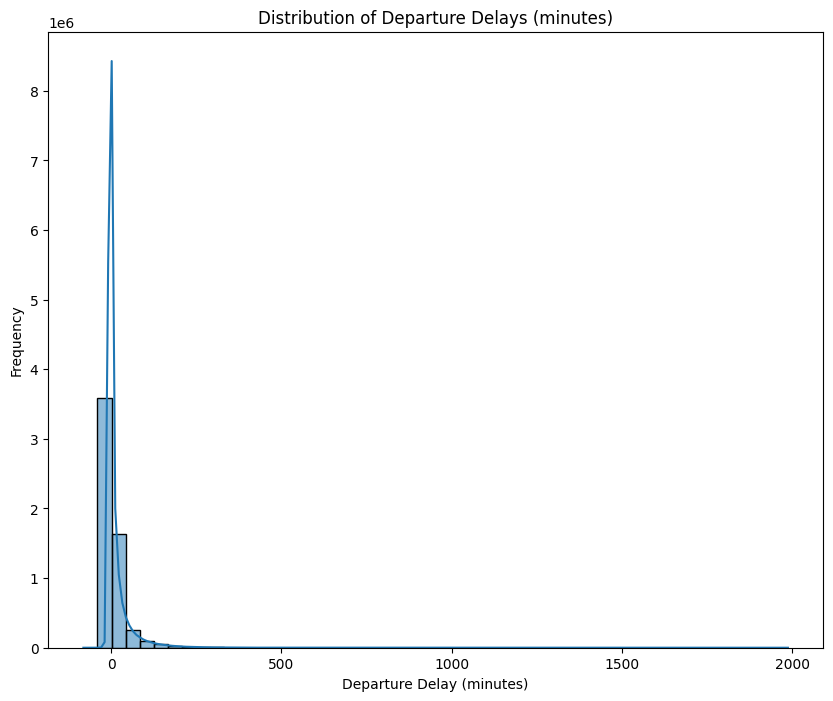

In [ ]:
delay_by_hour = df.groupby('HOUR')['DEPARTURE_DELAY_FLAG'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='HOUR', y='DEPARTURE_DELAY_FLAG', data=delay_by_hour, palette='viridis')
plt.title('Average Departure Delay Rate by Hour of Day')
plt.xlabel('Hour of Day (0 - 23)')
plt.ylabel('Delay Rate')
plt.grid(True)
plt.show()

AIRLINE_DELAY = df.groupby("AIRLINE")["DEPARTURE_DELAY_FLAG"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=AIRLINE_DELAY.index, y=AIRLINE_DELAY.values, palette="viridis")
plt.title("Average Departure Delay Rate by Airline")
plt.ylabel("Average Delay Rate")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

month_delay = df.groupby("MONTH")["DEPARTURE_DELAY_FLAG"].mean()
plt.figure(figsize=(10,5))
sns.barplot(x=month_delay.index, y=month_delay.values, palette="coolwarm")
plt.title("Average Departure Delay Rate by Month")
plt.xlabel("Month")
plt.ylabel("Average Delay Rate")
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter out rows with NaN in 'DAY_OF_WEEK' before plotting
df_filtered_dow = df.dropna(subset=['DAY_OF_WEEK'])
dow_delay = df_filtered_dow.groupby("DAY_OF_WEEK")["DEPARTURE_DELAY_FLAG"].mean()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_delay = dow_delay.reindex(ordered_days)
plt.figure(figsize=(10,5))
sns.barplot(x=dow_delay.index, y=dow_delay.values, palette="magma")
plt.title("Average Departure Delay Rate by Day of The Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Delay Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

ORIGIN_DELAY = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY_FLAG'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=ORIGIN_DELAY.index, y=ORIGIN_DELAY.values, palette='rocket')
plt.title("Top 10 Origin Airports by Average Departure Delay Rate")
plt.xlabel("Origin Airport")
plt.ylabel("Average Delay Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.histplot(df['DEPARTURE_DELAY_MINUTES'], bins=50, kde=True)
plt.title("Distribution of Departure Delays (minutes)")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

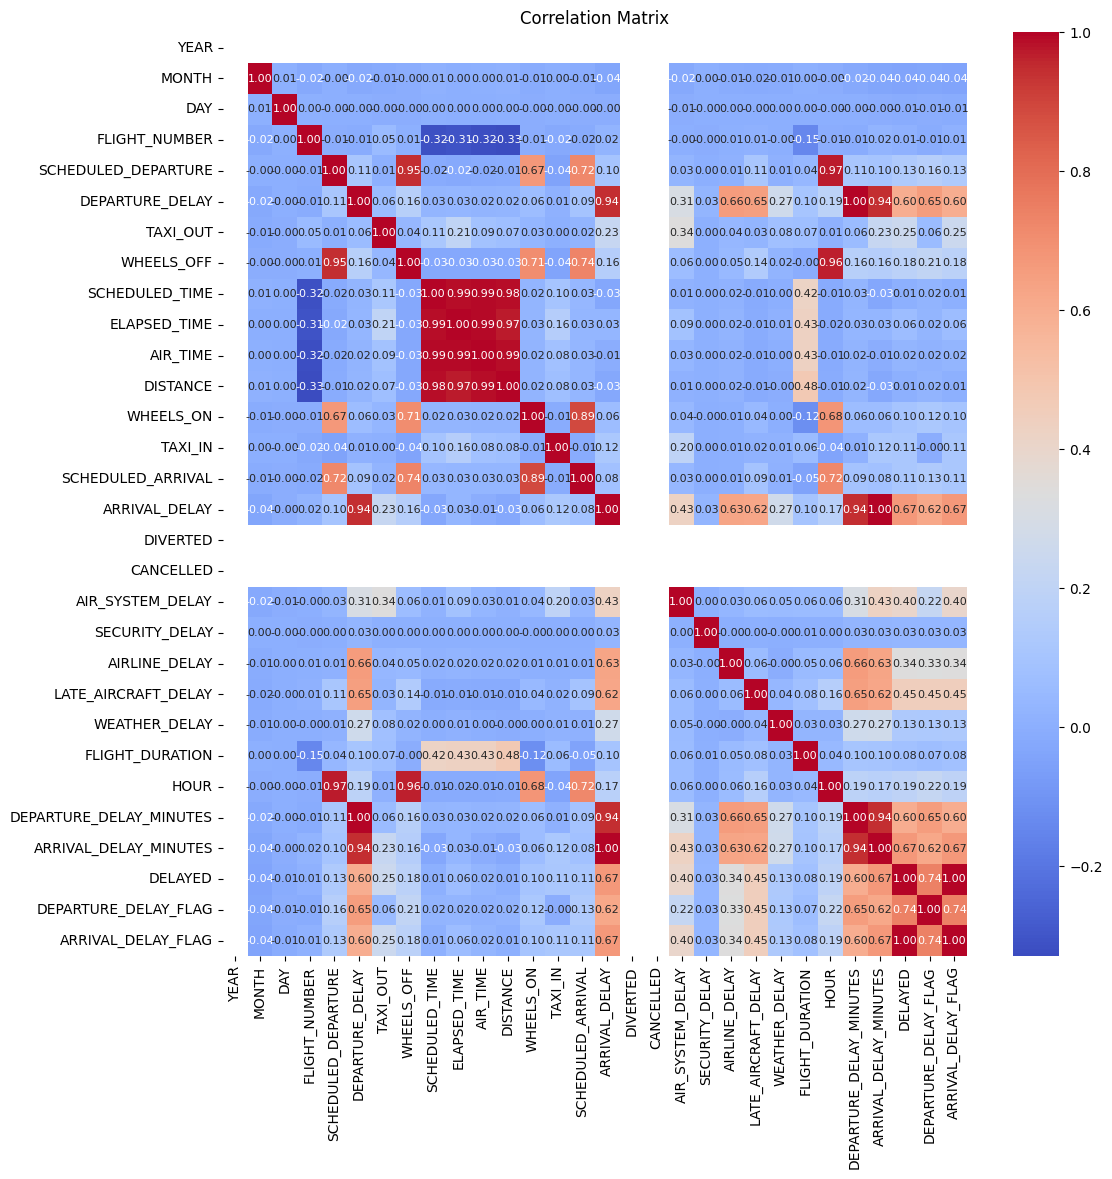

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 12))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size":8})
plt.title("Correlation Matrix")
plt.show()

# Feature Selection

In [ ]:
# Copy the DataFrame to avoid modifying original
df_cleaned = df.copy()

# Drop target leakage and post-departure columns
leakage_cols = [
    'ARRIVAL_DELAY', 'ARRIVAL_DELAY_MINUTES', 'ARRIVAL_TIME', 'WHEELS_ON',
    'WHEELS_OFF', 'TAXI_IN', 'TAXI_OUT', 'ELAPSED_TIME', 'AIR_TIME',
    'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'DEPARTURE_DELAY_MINUTES',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAYED'
]

df_cleaned.drop(columns=leakage_cols, inplace=True)

# Drop identifiers and post-analysis columns
drop_cols = ['FLIGHT_NUMBER', 'TAIL_NUMBER', 'FLIGHT_DATE']
df_cleaned.drop(columns=drop_cols, inplace=True)

# Separate features and target
target = 'ARRIVAL_DELAY_FLAG'
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

# Convert 'DAY_OF_WEEK' to string type to handle mixed types initially
X['DAY_OF_WEEK'] = X['DAY_OF_WEEK'].astype(str)

# Replace 'nan' string with actual NaN values
X['DAY_OF_WEEK'] = X['DAY_OF_WEEK'].replace('nan', np.nan)

## Encode categorical variables
categorical_cols = X.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    X[col] = X[col].astype(str)  # Ensure uniform type
    X[col] = X[col].fillna('Missing')  # Fill NaNs with a placeholder
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Impute any remaining missing numerical values
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the data before converting to numpy array to preserve column names
X_imputed = imputer.fit_transform(X)

# Convert imputed data back to DataFrame to easily drop rows with non-finite values
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns[:X_imputed.shape[1]])

# Drop rows with any remaining non-finite values in X_imputed_df and corresponding rows in y
# Reset index of y to match X_imputed_df
y = y.reset_index(drop=True)

# Now masking will work
non_finite_mask = X_imputed_df.isin([np.inf, -np.inf]).any(axis=1) | X_imputed_df.isnull().any(axis=1)

X_imputed_df_cleaned = X_imputed_df[~non_finite_mask]
y_cleaned = y[~non_finite_mask]

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_imputed_df_cleaned, y_cleaned)

# Get the selected feature names
mask = selector.get_support()
selected_features = X_imputed_df_cleaned.columns[mask].tolist()
selected_features

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 0 11 12 13] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


['MONTH',
 'DAY',
 'AIRLINE',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'SCHEDULED_ARRIVAL',
 'FLIGHT_DURATION',
 'HOUR',
 'DEPARTURE_DELAY_FLAG']

# Modeling

In [ ]:
# Prepare the final feature set (excluding DEPARTURE_DELAY_FLAG and DELAYED to avoid leakage at first)
features_to_use = [f for f in selected_features if f != 'DEPARTURE_DELAY_FLAG']

# Prepare X and y
X_model = X[features_to_use]
y_model = y

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

Random Forest Classifier

In [ ]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[915359  19196]
 [ 63898 138202]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96    934555
           1       0.88      0.68      0.77    202100

    accuracy                           0.93   1136655
   macro avg       0.91      0.83      0.86   1136655
weighted avg       0.92      0.93      0.92   1136655



Logistic Regression

In [ ]:
# Initialize and train Logistic Regression
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logreg = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logreg.fit(X_train_imputed, y_train)

# Predict and evaluate using standard metrics
y_pred = logreg.predict(X_test_imputed)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[738728 195827]
 [ 61093 141007]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85    934555
           1       0.42      0.70      0.52    202100

    accuracy                           0.77   1136655
   macro avg       0.67      0.74      0.69   1136655
weighted avg       0.83      0.77      0.79   1136655



XGBoost

In [ ]:
# Calculate the scale_pos_weight value
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:02:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[848824  85731]
 [ 51316 150784]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93    934555
           1       0.64      0.75      0.69    202100

    accuracy                           0.88   1136655
   macro avg       0.79      0.83      0.81   1136655
weighted avg       0.89      0.88      0.88   1136655



LightGBM


In [ ]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 808680, number of negative: 3737939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4546619, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[[847103  87452]
 [ 51432 150668]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92    934555
           1       0.63      0.75      0.68    202100

    accuracy                           0.88   1136655
   macro avg       0.79      0.83      0.80   1136655
weighted avg       0.89      0.88      0.88   1136655



# Evaluation

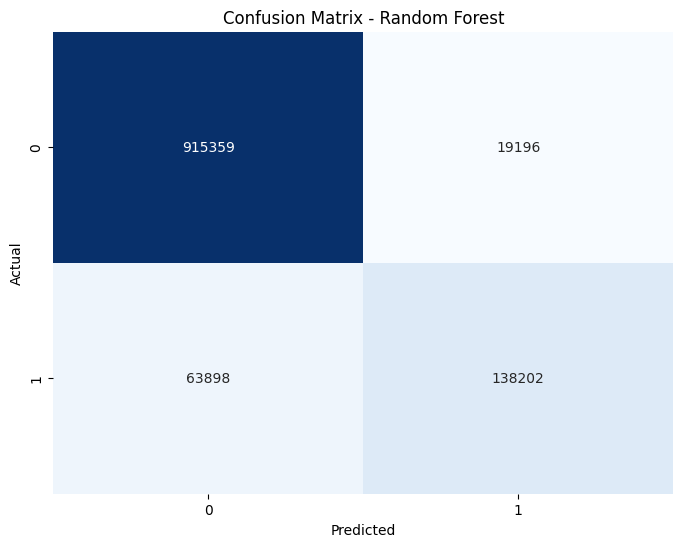

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96    934555
           1       0.88      0.68      0.77    202100

    accuracy                           0.93   1136655
   macro avg       0.91      0.83      0.86   1136655
weighted avg       0.92      0.93      0.92   1136655



In [ ]:
# Plot Confusion Matrix for Random Forest
y_pred_rf = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Classification Report for Random Forest
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

Precision-Recall Curve for each model

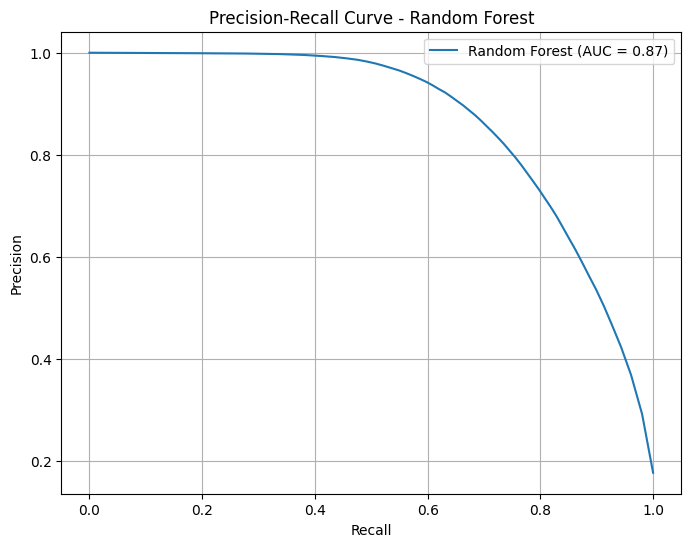

In [ ]:
# Random Forest
y_proba_rf = clf.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
auc_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.title('Precision-Recall Curve - Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

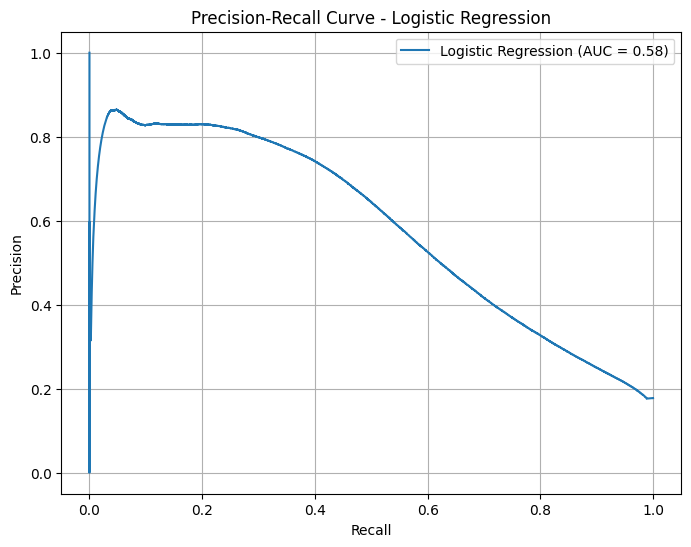

In [ ]:
# Logistic Regression
y_proba_lr = logreg.predict_proba(X_test_imputed)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
auc_lr = auc(recall_lr, precision_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

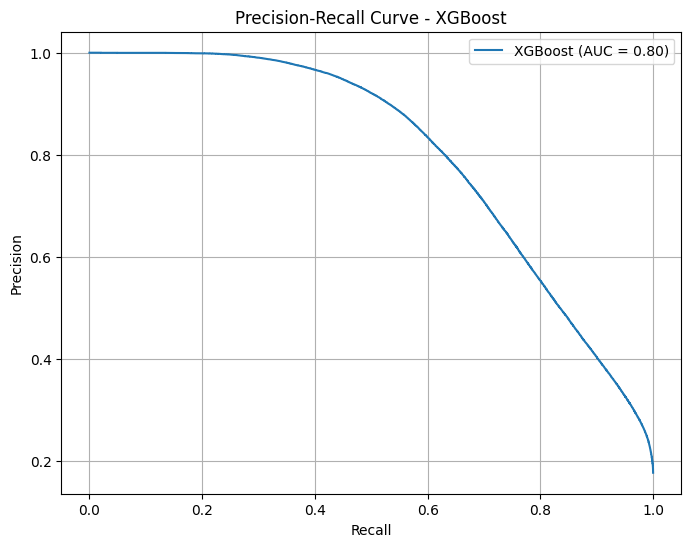

In [ ]:
# XGBoost
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
auc_xgb = auc(recall_xgb, precision_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.title('Precision-Recall Curve - XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

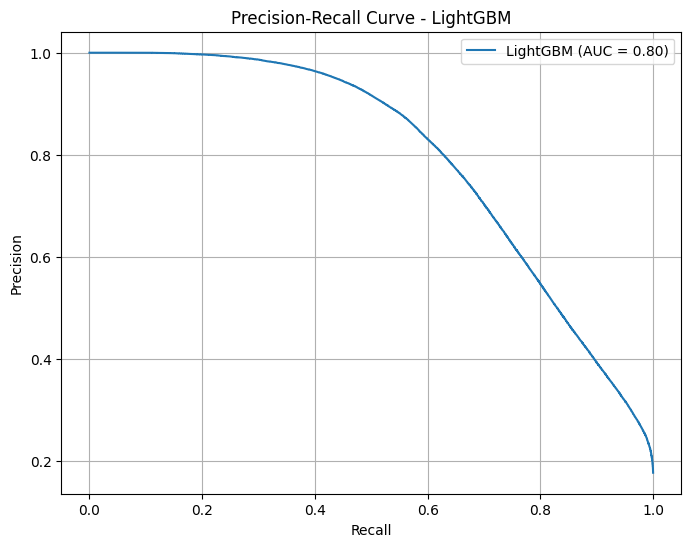

In [ ]:
# LightGBM
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_proba_lgbm)
auc_lgbm = auc(recall_lgbm, precision_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(recall_lgbm, precision_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')
plt.title('Precision-Recall Curve - LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()